In [1]:
# Koristimo "nepreporučeni" tip import-anja modula radi lakšeg daljnjeg korištenja.
from numpy import *;
from numpy.linalg import *;
from scipy.linalg import *;
from control.matlab import *;
from matplotlib.pyplot import *;

use_numpy_matrix(flag=False, warn=True)

In [2]:
# Definiramo matrice sustava za strujni krug s predavanja.
A = array( [
    [0, 0, -1, 0],
    [0, 0, 0, 1],
    [1, 0, -1, 0],
    [0, -1, 0, -1] ] );
B = array( [
    [1],
    [1],
    [0],
    [0] ] );
C = array( [[0, 0, 1, -1] ] );
D = array( [[0] ] );

sustav = ss( A, B, C, D );

In [3]:
# Odredimo dimenziju dohvatljivog prostora.
# Matrica upravljivosti.
def matr_upravljivosti( A, B ):
    # Uoči: ovo ipak može i bez C_AB = copy(B); prod = copy(B);
    C_AB = B; prod = B;
    
    [n, m] = shape( B );
    for i in range( 0, n-1 ):
        prod = A @ prod;
        C_AB = block( [C_AB, prod] );
    return C_AB;

C_AB = matr_upravljivosti( A, B );
print( C_AB );

rang = matrix_rank( C_AB ); # iz numpy.linalg
print( 'Rang matrice C(A, B) je ', rang );

[[ 1  0 -1  1]
 [ 1  0 -1  1]
 [ 0  1 -1  0]
 [ 0 -1  1  0]]
Rang matrice C(A, B) je  2


In [4]:
# Ovo možemo i pomoću funkcija ctrb iz paketa control.

# Matrica upravljivosti:
CAB = ctrb( A, B ); # iz control.matlab
print( CAB );

[[ 1.  0. -1.  1.]
 [ 1.  0. -1.  1.]
 [ 0.  1. -1.  0.]
 [ 0. -1.  1.  0.]]


In [5]:
# Definiramo matricu transformacije za formu upravljivosti.
Tinv = array( [
    [1, 0, 1, 0],
    [1, 0, 0, 0],
    [0, 1, 0, 0],
    [0, -1, 0, 1] ] );

# Može i ovako:
# Tinv = copy( C_AB[:, 0:2] );
# e1 = array( [1, 0, 0, 0] );
# e4 = array( [0, 0, 0, 1] );
# Tinv = block( [Tinv, e1.reshape( 4, 1 ), e4.reshape( 4, 1 )] );

# T = inverz od Tinv
T = array( [
    [0, 1, 0, 0],
    [0, 0, 1, 0],
    [1, -1, 0, 0],
    [0, 0, 1, 1] ] );

# Ili, bez manualnog računanja, pomoću funkcija iz scipy.linalg:
# T = inv( Tinv );

# Forma upravljivosti.
Au = T @ A @ Tinv;
Bu = T @ B;

print( 'Matrica A iz forme upravljivosti:\n', Au );
print( 'Matrica B iz forme upravljivosti:\n', Bu );

Matrica A iz forme upravljivosti:
 [[ 0 -1  0  1]
 [ 1 -1  1  0]
 [ 0  0  0 -1]
 [ 0  0  1 -1]]
Matrica B iz forme upravljivosti:
 [[1]
 [0]
 [0]
 [0]]


In [6]:
# Pokažimo da su svojstvene vrijednosti od A_22 neupravljive.
[lam, X] = eig( Au[2:, 2:] );
print( 'Svojstvene vrijednosti od A_22:\n', lam );

M1 = block( [A-lam[0]*eye(4), B] );
M2 = block( [A-lam[1]*eye(4), B] );
M3 = block( [A-2*eye(4), B] );

rang_M1 = matrix_rank( M1 );
rang_M2 = matrix_rank( M2 );
rang_M3 = matrix_rank( M3 );

print( 'Rang od [A-lam0*I B] je: ', rang_M1 ); # <4 -> neupravljivo
print( 'Rang od [A-lam1*I B] je: ', rang_M2 ); # <4 -> neupravljivo
print( 'Rang od [A-2*I B] je:    ', rang_M3 ); # =4 -> upravljivo

Svojstvene vrijednosti od A_22:
 [-0.5+0.8660254j -0.5-0.8660254j]
Rang od [A-lam0*I B] je:  3
Rang od [A-lam1*I B] je:  3
Rang od [A-2*I B] je:     4


In [7]:
# Matrica osmotrivosti.
def matr_osmotrivosti( A, C ):
    O_CA = C; prod = C;
    [p, n] = shape( C );
    for i in range( 0, n-1 ):
        prod = prod @ A;
        O_CA = block( [[O_CA], [prod]] ); # Pazi: prod ide ispod O_CA, a ne desno
    return O_CA;
    
O_CA = matr_osmotrivosti( A, C );
print( O_CA );
print( matrix_rank( O_CA ) );

# Ponovno, u control.matlab postoji funkcija obsv koja računa matricu osmotrivosti.
print( obsv( A, C ) );

[[ 0  0  1 -1]
 [ 1  1 -1  1]
 [-1 -1  0  0]
 [ 0  0  1 -1]]
2
[[ 0.  0.  1. -1.]
 [ 1.  1. -1.  1.]
 [-1. -1.  0.  0.]
 [ 0.  0.  1. -1.]]


In [8]:
# Definiramo matricu transformacije za formu osmotrivosti.
# Promotrimo stupce koji razapinju sliku matrice O_CA.T.
print( O_CA.T )

# Uzmemo njih i dopunimo do baze prostora.
# Time dobivamo T1_inv takvu da je par (T1*A.T*T1_inv, T*C.T) u formi upravljivosti.
# Nama treba T takav da je (C*T_inv, T_inv*A*T) u formi osmotrivosti. 
# Transponiranjem lako slijedi da je T = T1_inv.T
T1_inv = array( [
    [ 0, -1,  1, 0],
    [ 0, -1, -1, 0],
    [ 1,  0,  0, 1],
    [-1,  0,  0, 1] ] );
T = T1_inv.T;
print( T );

[[ 0  1 -1  0]
 [ 0  1 -1  0]
 [ 1 -1  0  1]
 [-1  1  0 -1]]
[[ 0  0  1 -1]
 [-1 -1  0  0]
 [ 1 -1  0  0]
 [ 0  0  1  1]]


In [9]:
# Ispisujemo formu osmotrivosti.
Abar = T @ A @ inv(T);
Cbar = C @ inv(T);

print( 'Matrica A iz forme osmotrivosti:\n', Abar );
print( 'Matrica C iz forme osmotrivosti:\n', Cbar );

Matrica A iz forme osmotrivosti:
 [[-1. -1.  0.  0.]
 [ 1.  0.  0.  0.]
 [ 0.  0.  0. -1.]
 [ 0.  0.  1. -1.]]
Matrica C iz forme osmotrivosti:
 [[1. 0. 0. 0.]]


In [10]:
# Pokažimo da su svoj. vrijednosti od Abar22 neosmotrive.
[lam, X] = eig( Abar[2:, 2:] )
print( lam )

print( matrix_rank( vstack( (A - lam[0]*eye(4), C) ) ) )
print( matrix_rank( vstack( (A - lam[1]*eye(4), C) ) ) )

# Alternativno, pomoću block.
# Pokažimo da su svojstvene vrijednosti od A_22 neosmotrive.
[lam, X] = eig( Abar[2:, 2:] );
print( 'Svojstvene vrijednosti od A_22:\n', lam );

M1 = block( [[A-lam[0]*eye(4)], [C]] ); # Pazi: C ide ispod A-lam*I, a ne desno
M2 = block( [[A-lam[1]*eye(4)], [C]] );
M3 = block( [[A-2*eye(4)], [C]] );

rang_M1 = matrix_rank( M1 );
rang_M2 = matrix_rank( M2 );
rang_M3 = matrix_rank( M3 );

print( 'Rang od [A-lam0*I; C] je: ', rang_M1 ); # <4 -> neosmotrivo
print( 'Rang od [A-lam1*I; C] je: ', rang_M2 ); # <4 -> neosmotrivo
print( 'Rang od [A-2*I; C] je:    ', rang_M3 ); # =4 -> osmotrivo

[-0.5+0.8660254j -0.5-0.8660254j]
3
3
Svojstvene vrijednosti od A_22:
 [-0.5+0.8660254j -0.5-0.8660254j]
Rang od [A-lam0*I; C] je:  3
Rang od [A-lam1*I; C] je:  3
Rang od [A-2*I; C] je:     4


In [11]:
# Postoji realizacija sustava koja je manjeg reda.
sustav_min = minreal( sustav );
sustav_min

2 states have been removed from the model


StateSpace(array([[ 0.,  1.],
       [-1., -1.]]), array([[1.41421356],
       [0.        ]]), array([[ 0.        , -1.41421356]]), array([[0.]]))

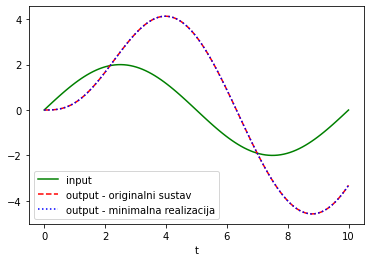

In [12]:
# sustav i sustav_min daju isti izlaz za isti ulaz (tj. realizacija su istog sustava)!
# Vremenski interval i input;
t = linspace( 0, 10, 100 );

# Input.
def uu( t ):
    return 2*sin( t/10*2*math.pi );
    
u = list( map( uu, t ) );

# Početno stanje.
x0 = array( [[0], [0], [0], [0]] );
x0_min = array( [[0], [0]] );

# Simulacija: yout = izlaz, tout = vremena, xout = stanja.
[yout, tout, xout] = lsim( sustav, u, t, x0 );
[yout_min, tout_min, xout_min] = lsim( sustav_min, u, t, x0_min );

# Crtamo outpute yout i yout_min.
%matplotlib inline

f = figure;
plot( t, u, 'g-', label='input' );
plot( tout, yout, 'r--', label='output - originalni sustav' );
plot( tout_min, yout_min, 'b:', label='output - minimalna realizacija' );
xlabel( 't' );
legend();
show();